# Feature Engineering

0. manual creation of new features
1. filter methods
2. wrapper methods
3. embedded methods
4. linear dimensionality reduction

## Filter Methods

- not running an entire model  

### 1. Correlation 

- features to target  
- within features  

### 2. Select K-best

- removes n-k features
- must identify your k
- f_regression: correlation is computed => f score => pval


## Wrapper Methods

- evaluate based on the performance of your ML algorithm

### Backward elimination

- run model, check, remove the worse
- iterate

### Forward selection


### Recursive feature elimination (RFE)

- take the model and number of features provided, and return ranking of all variables and its support (T/F)

## Embedded Methods

- penalize the worst performing features

- LassoCV  
- ElasticNet  
- RidgeRegression  
- Regularized Regression  

## Linear Dimensionality Reduction

- PCA: principle components analysis


_________________________________________
_________________________________________


In [99]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('student_grades.csv')

df = df.replace(r'^\s+$', np.nan, regex=True)
df.dropna(inplace=True)
df = df.astype('int')

### Construct new features

In [100]:
df['exam_1to2'] = df['exam1'] - df['exam2']
df['exam_1to3'] = df['exam1'] - df['exam3']
df['exam_2to3'] = df['exam2'] - df['exam3']

df.drop(columns=['student_id', 'exam2', 'exam3'], inplace=True)

In [101]:
df.describe()

,exam1,final_grade,exam_1to2,exam_1to3,exam_2to3
count,102.000000,102.000000,102.000000,102.000000,102.000000
mean,78.705882,81.852941,1.205882,-5.558824,-6.764706
std,14.305429,10.953002,5.925842,6.551507,3.629299
min,57.000000,65.000000,-8.000000,-18.000000,-15.000000
25%,70.000000,72.000000,-5.000000,-8.000000,-9.000000
50%,79.000000,81.000000,3.000000,-3.000000,-5.000000
75%,92.000000,93.000000,5.000000,-2.000000,-5.000000
max,100.000000,97.000000,10.000000,5.000000,-3.000000


### Split & Scale

In [141]:
# split into train and test
train, test = split_scale.split_my_data(df)
X_train = train.drop(columns=['final_grade'])
y_train = train[['final_grade']]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_train)
X_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns.values).set_index([X_train.index.values])

In [142]:
train_scaled = X_scaled.join(pd.DataFrame(y_train))

train_scaled.describe()

,exam1,exam_1to2,exam_1to3,exam_2to3,final_grade
count,81.000000,81.000000,81.000000,81.000000,81.000000
mean,0.464829,0.477366,0.508320,0.674897,80.641975
std,0.314244,0.315345,0.274950,0.301502,10.506318
min,0.000000,0.000000,0.000000,0.000000,65.000000
25%,0.302326,0.166667,0.434783,0.500000,72.000000
50%,0.511628,0.611111,0.652174,0.833333,81.000000
75%,0.651163,0.611111,0.695652,0.833333,87.000000
max,1.000000,1.000000,1.000000,1.000000,97.000000


### Correlation threshold

In [143]:
plt.figure(figsize=(6,5))
cor = train_scaled.corr()
cor
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

,exam1,exam_1to2,exam_1to3,exam_2to3,final_grade
exam1,1.000000,0.761832,0.890671,0.361562,0.984444
exam_1to2,0.761832,1.000000,0.823506,-0.129488,0.735541
exam_1to3,0.890671,0.823506,1.000000,0.455897,0.844376
exam_2to3,0.361562,-0.129488,0.455897,1.000000,0.321892
final_grade,0.984444,0.735541,0.844376,0.321892,1.000000


<Figure size 432x360 with 0 Axes>

### Select K-Best
SelectKBest removes all but the highest scoring features
Scores are the test statistic for the chosen function or test (Chi-squared, F-regression, etc.)


In [144]:
from sklearn.feature_selection import SelectKBest, f_regression

f_selector = SelectKBest(f_regression, k=3).fit(X_scaled, y_train)

f_support = f_selector.get_support()
print(f_support)
print(X_train.loc[:,f_support].columns.tolist())

f_selector.scores_

[ True  True  True False]
['exam1', 'exam_1to2', 'exam_1to3']


array([2480.06685901,   93.12086279,  196.23278584,    9.13171426])

### Wrapper Methods

In [145]:
# backward elimination with OLS
import statsmodels.api as sm

In [146]:
cols = list(X_scaled.columns)
pmax = 1

while (len(cols) > 0):
    p = []
    x_1 = X_scaled[cols]
#     x_1 = sm.add_constant(x_1)
    model = sm.OLS(y_train, x_1).fit()
    p = pd.Series(model.pvalues.values[0:,],index=cols)
    pmax = max(p)
    feature_with_pmax = p.idxmax()
    #  = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_pmax)
    else:
        break    

In [147]:
cols

['exam1', 'exam_1to2', 'exam_1to3', 'exam_2to3']

### Recursive Feature Engineering

In [148]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [149]:
reg = LinearRegression()
rfe = RFE(reg, 3)
X_rfe = rfe.fit_transform(X_scaled, y_train)

In [150]:
reg.fit(X_rfe, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [151]:
pd.Series(rfe.support_, index=cols)

exam1         True
exam_1to2     True
exam_1to3     True
exam_2to3    False
dtype: bool

In [152]:
print(type(X_rfe))

print(X_rfe.shape)

<class 'numpy.ndarray'>
(81, 3)


In [153]:
X_scaled.columns.values

array(['exam1', 'exam_1to2', 'exam_1to3', 'exam_2to3'], dtype=object)

### Embedded Methods

#### Lasso CV

In [154]:
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(X_scaled, y_train)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [155]:
reg.alpha_

0.0032100608599795123

In [156]:
reg.score(X_scaled, y_train)

0.9744156295905129

In [157]:
reg.coef_

array([37.13390386, -0.        , -5.2032431 , -0.57778213])

In [158]:
y_train['yhat'] = reg.predict(X_scaled)

y_train.head()

,final_grade,yhat
86,77,75.283862
21,77,75.283862
31,81,82.699915
33,76,76.132043
102,65,66.175167


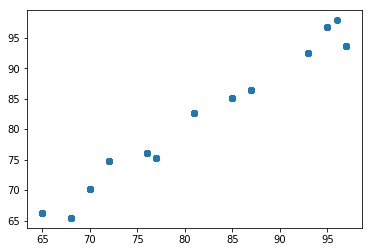

In [160]:
plt.scatter(y_train.final_grade, y_train.yhat)

In [161]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train.final_grade, y_train.yhat)

2.7892072041606353

### PCA

In [162]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, copy=True, whiten=False, svd_solver='auto', random_state=123)
X = pca.fit_transform(X_scaled)
print(pca.n_components_)
print(len(X))
print(pca.explained_variance_ratio_)
print(X[0:5])

2
81
[0.68169599 0.28208848]
[[-0.1147069   0.57401947]
 [-0.1147069   0.57401947]
 [ 0.14329329  0.80960063]
 [ 0.15289437 -0.085889  ]
 [-0.87140374  0.05934817]]


In [163]:
X_pc = pd.DataFrame(X)
X_pc.head()

,0,1
0,-0.114707,0.574019
1,-0.114707,0.574019
2,0.143293,0.809601
3,0.152894,-0.085889
4,-0.871404,0.059348


In [90]:
reg = LinearRegression().fit(X_pc, y_train)
y_train['yhat'] = reg.predict(X_pc)

In [91]:
mean_squared_error(y_train.final_grade, y_train.yhat)

0.016008114632549742

In [92]:
X_train.describe()

,exam1,exam_1to2,exam_1to3,exam_2to3
count,81.000000,81.000000,81.000000,81.000000
mean,0.464829,0.477366,0.508320,0.674897
std,0.314244,0.315345,0.274950,0.301502
min,0.000000,0.000000,0.000000,0.000000
25%,0.302326,0.166667,0.434783,0.500000
50%,0.511628,0.611111,0.652174,0.833333
75%,0.651163,0.611111,0.695652,0.833333
max,1.000000,1.000000,1.000000,1.000000


In [93]:
X_pc.describe()

,0,1
count,8.100000e+01,8.100000e+01
mean,-1.987436e-17,-5.418334e-17
std,4.986079e-01,3.207424e-01
min,-8.714037e-01,-4.193818e-01
25%,-2.363312e-01,-1.972840e-01
50%,1.528944e-01,-2.961139e-02
75%,3.087946e-01,4.778478e-02
max,9.077345e-01,8.096006e-01
